# MEB: Coarsen Multiple Eigenvectors around a fixed $\lambda$

## $\lambda = 0$

### Set up Fine-level Eigenproblem

In [351]:
%run /Users/olivne/multigrid/amgplus/src/helmholtz/startup.ipy
from scipy.sparse.linalg import eigsh
from scipy.linalg import subspace_angles
import meb.coarsening

np.set_printoptions(precision=3)

In [352]:
# Fixed seed for reproducible results.
np.random.seed(0)

# Domain size.
n = 100
domain_size = 1
discretization = "3-point"
# lambda = -(k h)^2 in Helmholtz; here this quantity is lam = lambda * h^2 where lamnda is the eigenvalue, because a, b are normalized.
kh = 0 # 0.5
lam = kh ** 2

# Test vectors.
num_tv = 10
num_sweeps_tv = 20 # None

# Relaxation shrinkage.
leeway_factor = 1.3

# Interpolation.
interpolation_method = "ls"
fit_scheme = "plain"
weighted = False #True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5

# Cycles.
nu_values = np.arange(1, 6)

In [353]:
# Create fine-level eigenproblem: -Delta u = lam u with periodic BC.
level = meb.coarsening.create_eigenproblem(domain_size, n, hm.solve.relax.GsRelaxer if lam == 0 else hm.solve.relax.KaczmarzRelaxer)
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)
_LOGGER.info("lam {}".format(lam))
_LOGGER.info("domain size {} n {} h {}".format(level.domain_size, n, level.domain_size / n))

INFO     lam 0
INFO     domain size 1 n 100 h 0.01


### Relaxation

In [354]:
# Check that relaxation on A*x - lam*B*x = 0 is equivalent to the corresponding relaxation for Helmholtz operator with
# lam = -(kh)^2.
relaxer = level._relaxer
b = np.zeros((n, ))
np.random.seed(0)
x = 2 * np.random.random((n, )) - 1
y = relaxer.step(x, b, lam=lam)

a_hm = -hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
relaxer_hm = hm.solve.relax.GsRelaxer(a_hm, level.b) if lam == 0 else hm.solve.relax.KaczmarzRelaxer(a_hm, level.b)
y_hm = relaxer_hm.step(x, b)

norm(y - y_hm), norm((level.a - lam * level.b - a_hm).todense())

(0.0, 0.0)

INFO     relax
INFO     Iter     |r|                         |x|         RER
INFO     0     9.295e-01                    4.468e-01    2.075
INFO     1     3.441e-01 (0.371) [0.371]    2.516e-01    1.373 (0.661)
INFO     2     1.428e-01 (0.417) [0.393]    1.848e-01    0.780 (0.569)
INFO     3     8.127e-02 (0.570) [0.446]    1.581e-01    0.517 (0.667)
INFO     4     6.571e-02 (0.807) [0.518]    1.441e-01    0.457 (0.885)
INFO     5     6.101e-02 (0.928) [0.582]    1.351e-01    0.452 (0.990)
INFO     6     5.860e-02 (0.960) [0.633]    1.284e-01    0.456 (1.010)
INFO     7     5.679e-02 (0.969) [0.672]    1.231e-01    0.461 (1.011)
INFO     8     5.524e-02 (0.973) [0.704]    1.187e-01    0.466 (1.009)
INFO     9     5.385e-02 (0.975) [0.730]    1.148e-01    0.469 (1.007)
INFO     10    5.260e-02 (0.977) [0.752]    1.115e-01    0.472 (1.006)
INFO     11    5.147e-02 (0.978) [0.770]    1.086e-01    0.474 (1.005)
INFO     12    5.043e-02 (0.980) [0.785]    1.059e-01    0.476 (1.004)
INFO    

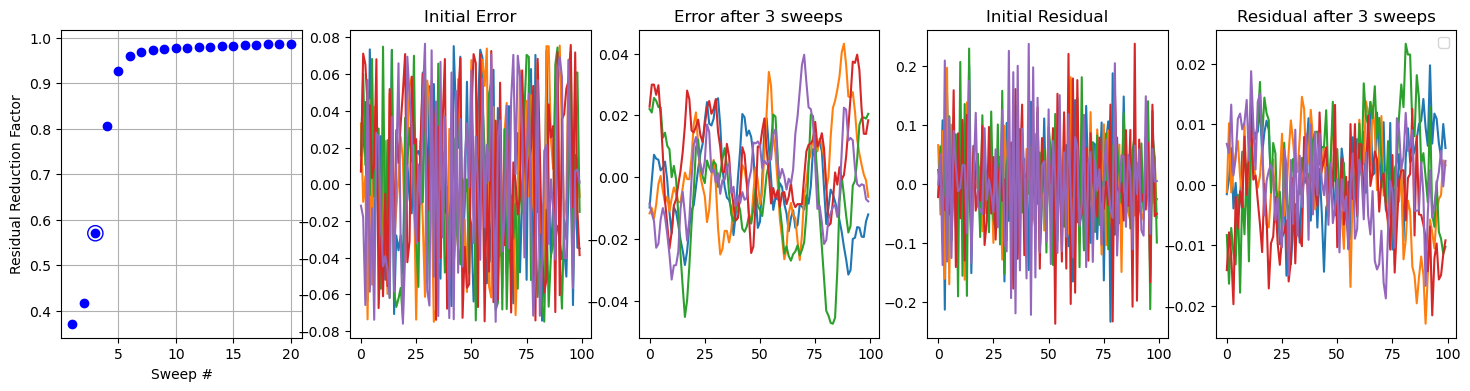

In [355]:
np.random.seed(0)
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.99, num_examples=5, lam=0.5)
num_sweeps = method_info["relax"][1]

## Coarsening: Geometric 2/1
Each coarse variable is the average of two adjacent fine variables.

The mock cycle rates improve with increasing $\nu$ (#relaxations per CGC). Note that injection 2/1 coarsening reports mock cycle rates that stall at $0.5$ with increasing $nu$ (#relaxations per CGC).

In [356]:
aggregate_size = 2
num_components = 1

# Averaging.
r_stencil = helmholtz.repetitive.coarsening_repetitive.Coarsener(np.array([[0.5, 0.5]]))
# Convert to sparse matrix + tile over domain.
R = r_stencil.tile(level.a.shape[0] // aggregate_size)

# Injection.
r_stencil = helmholtz.repetitive.coarsening_repetitive.Coarsener(np.array([[1, 0]]))
# Convert to sparse matrix + tile over domain.
R_injection = r_stencil.tile(level.a.shape[0] // aggregate_size)

pd.DataFrame(
    [
        [hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in nu_values], 
        [hm.setup.auto_setup.mock_cycle_conv_factor(level, R_injection, nu) for nu in nu_values], 
    ], columns=nu_values, index=("Averaging", "Injection"))

,1,2,3,4,5
Averaging,0.3250,0.1291,0.0835,0.0218,0.0265
Injection,0.6545,0.5386,0.5644,0.5672,0.5460


## Coarse-level Eigenproblem Accuracy

In [357]:
l, vf = eigsh(level.a, M=level.b, k=n-1)
l_max = max(l)
coarse_level = meb.coarsening.create_coarsening(level, num_tv, num_sweeps_tv, 2)
nc = coarse_level.a.shape[0]
lf = l[:nc-1]

In [358]:
# Subspace angles between fine and interpolated coarse eigenfunctions. Will only besmall if all eigenvalues of
# the ~same value are included.
angles = [subspace_angles(vf[:, :i], vcf[:, :i])[0] for i in range(1, len(lf) + 1)]
pd.DataFrame(np.stack((lf, lc, np.abs(lf - lc)/np.abs(lf), angles)).T, index=np.arange(1, len(lf) + 1),
            columns=("lam-f", "lam-c", "lam-err", "v-angle"))[:10]

,lam-f,lam-c,lam-err,v-angle
1,0.0039,0.0040,0.0069,1.0087
2,0.0039,0.0040,0.0151,0.0089
3,0.0158,0.0158,0.0024,1.1041
4,0.0158,0.0158,0.0042,0.0090
5,0.0354,0.0355,0.0013,1.2162
6,0.0354,0.0355,0.0028,0.0097
7,0.0628,0.0629,0.0014,1.0350
8,0.0628,0.0630,0.0023,0.0106
9,0.0979,0.0981,0.0019,1.5600
10,0.0979,0.0981,0.0024,0.0118


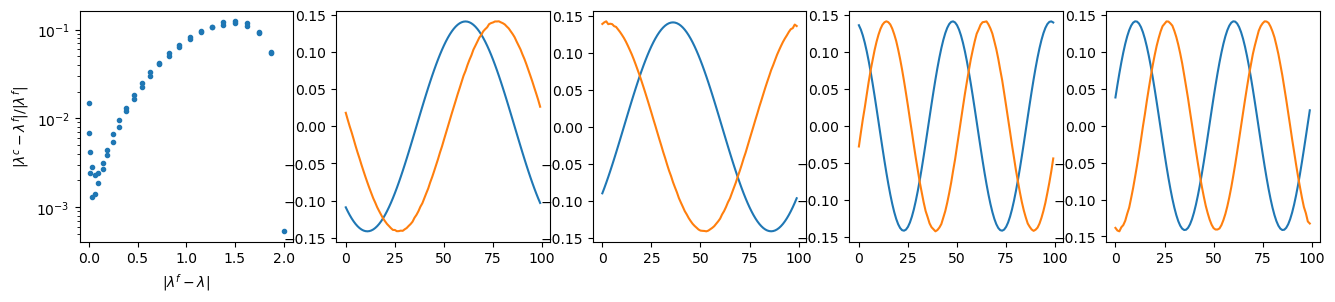

In [359]:
k = 4
fig, axs = plt.subplots(1, k + 1, figsize=(16, 3))

ax = axs[0]
ax.semilogy(np.abs(lf - lam), np.abs(lc - lf) / np.abs(lf), '.')
ax.set_xlabel("$|\\lambda^f- \\lambda|$")
ax.set_ylabel("$|\\lambda^c- \\lambda^f|/|\\lambda^f|$");

for i, ax in enumerate(axs[1:]):
    ax.plot(vf[:, i])
    ax.plot(vcf[:, i])
    #ax.grid(True);

### Effect of TF Smoothing

mean_error [0.2498 0.073  0.013  0.0086]


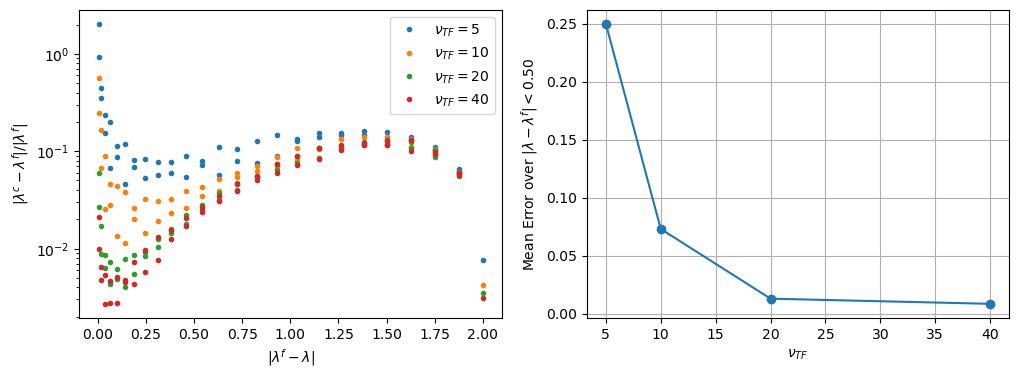

In [360]:
num_tv = 10
num_sweeps_tv_values = (5, 10, 20, 40)
lam_interval = l_max * 0.125

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ax = axs[0]
mean_error = [None] * len(num_sweeps_tv_values)
for i, num_sweeps_tv in enumerate(num_sweeps_tv_values):
    coarse_level = meb.coarsening.create_coarsening(level, num_tv, num_sweeps_tv, 2)
    lc, vc = eigsh(coarse_level.a, M=coarse_level.b, k=coarse_level.a.shape[0]-1)
    vcf = coarse_level.interpolate(vc)
    error = np.abs(lc - lf) / np.abs(lf)
    mean_error[i] = np.mean(error[np.abs(lf - lam) < lam_interval])
    
    ax.semilogy(np.abs(lf - lam), error, '.', label="$\\nu_{{TF}} = {}$".format(num_sweeps_tv))
    ax.set_xlabel("$|\\lambda^f- \\lambda|$")
    ax.set_ylabel("$|\\lambda^c- \\lambda^f|/|\\lambda^f|$");
ax.legend();
mean_error = np.array(mean_error)

ax = axs[1]
ax.plot(num_sweeps_tv_values, mean_error, '-o');
ax.set_xlabel("$\\nu_{{TF}}$")
ax.set_ylabel("Mean Error over $|\\lambda- \\lambda^f| < {:.2f}$".format(lam_interval));
ax.grid(True)
print("mean_error", np.array2string(mean_error, precision=4))

Looks like the smallest eigenvalues become more accurate, but on average the eigenvalue accuracy improvement for an $O(1)$-size interval has minimishing return vs. #TF sweeps.

### Effect of Number of TFs

/Users/olivne/opt/miniconda3/envs/amgp/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/olivne/opt/miniconda3/envs/amgp/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


mean_error [0.1326 0.0176 0.0111 0.0108]


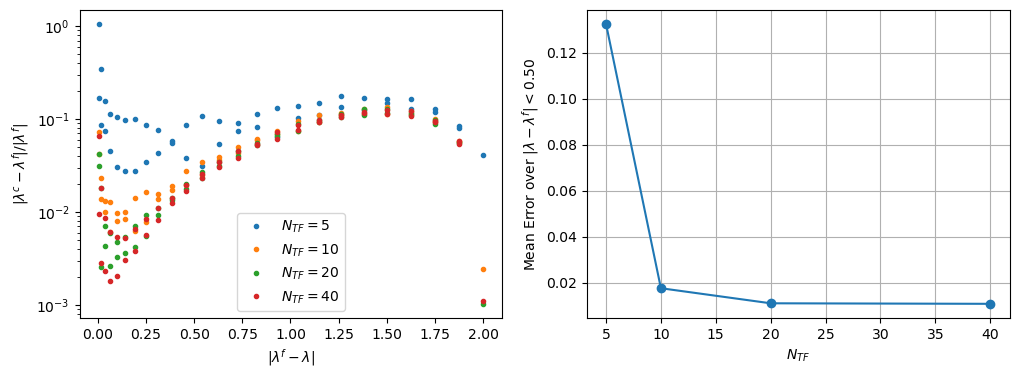

In [361]:
num_sweeps_tv = 20
num_tv_values = (5, 10, 20, 40)
lam_interval = max(l) * 0.125

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
ax = axs[0]
mean_error = [None] * len(num_tv_values)
for i, num_tv in enumerate(num_tv_values):
    coarse_level = meb.coarsening.create_coarsening(level, num_tv, num_sweeps_tv, 2)
    lc, vc = eigsh(coarse_level.a, M=coarse_level.b, k=coarse_level.a.shape[0]-1)
    vcf = coarse_level.interpolate(vc)
    error = np.abs(lc - lf) / np.abs(lf)
    mean_error[i] = np.mean(error[np.abs(lf - lam) < lam_interval])
    
    ax.semilogy(np.abs(lf - lam), error, '.', label="$N_{{TF}} = {}$".format(num_tv))
    ax.set_xlabel("$|\\lambda^f- \\lambda|$")
    ax.set_ylabel("$|\\lambda^c- \\lambda^f|/|\\lambda^f|$");
ax.legend();
mean_error = np.array(mean_error)

ax = axs[1]
ax.plot(num_tv_values, mean_error, '-o');
ax.set_xlabel("$N_{{TF}}$")
ax.set_ylabel("Mean Error over $|\\lambda- \\lambda^f| < {:.2f}$".format(lam_interval));
ax.grid(True)
print("mean_error", np.array2string(mean_error, precision=4))

Accuracy reaches asymptotic limit for $\gt 20$ TFs.

# Neighborhood around a fixed $\lambda > 0$

### Relaxation Shrinkage

In [362]:
b = np.zeros((level.a.shape[0], 1))
operator = lambda x: level.a.dot(x)
relaxer_gs = hm.solve.relax.GsRelaxer(level.a, level.b)
relaxer_kac = hm.solve.relax.KaczmarzRelaxer(level.a, level.b)

def info(relaxer, lam):
    relax = lambda x, b: relaxer.step(x, b, lam=lam)
    result = hm.solve.smoothing.shrinkage_factor(
            operator, relax, (n,), print_frequency=None, max_sweeps=30,
            slow_conv_factor=1.1, leeway_factor=1.2, output="stats")
    return result[0], result[5]

In [363]:
kh_values = np.linspace(0, 2, 20)
info_gs = np.array([info(relaxer_gs, kh ** 2) for kh in kh_values])
info_kac = np.array([info(relaxer_kac, kh ** 2) for kh in kh_values])

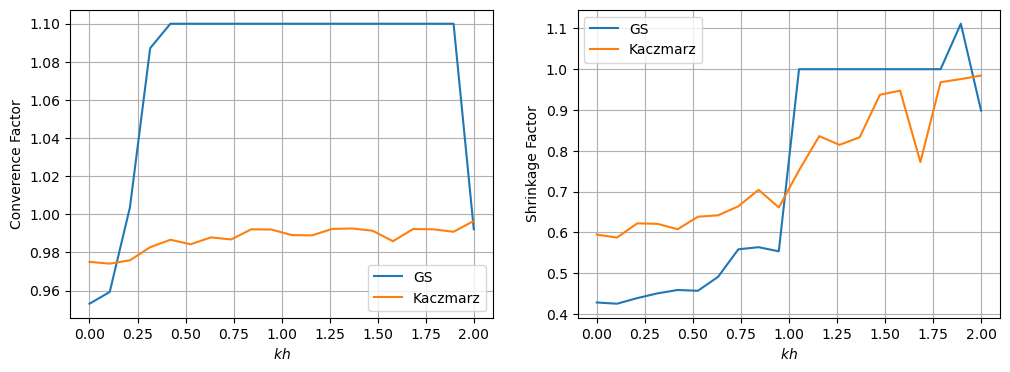

In [364]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
ax.plot(kh_values, np.clip(info_gs[:, 1], None, 1.1), label="GS")
ax.plot(kh_values, info_kac[:, 1], label="Kaczmarz")
ax.set_xlabel("$kh$")
ax.set_ylabel("Converence Factor");
ax.legend();
ax.grid(True)

ax = axs[1]
ax.plot(kh_values, info_gs[:, 0], label="GS")
ax.plot(kh_values, info_kac[:, 0], label="Kaczmarz")
ax.set_xlabel("$kh$")
ax.set_ylabel("Shrinkage Factor");
ax.legend();
ax.grid(True);

Note: convergence factor clipped at 1.1.
Kaczmarz has worse smoothing but guaranteed convergence. GS only good till $kh \approx 0.2$.

## Mock Cycle Predictions

In [365]:
def create_svd_coarsening(level):
    # Generate relaxed test matrix.
    n = level.a.shape[0]
    x = hm.solve.run.random_test_matrix((n,))
    b = np.zeros_like(x)
    x, _ = hm.solve.run.run_iterative_method(level.operator, lambda x: level.relax(x, b), x, num_sweeps=100)
    # Generate coarse variables (R) based on a window of x.
    aggregate_size = 4
    num_components = 2
    x_aggregate_t = x[:aggregate_size].transpose()
    coarsener, _ = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)    
    # Convert to sparse matrix + tile over domain.
    r_csr = coarsener.tile(n // aggregate_size)
    return r_csr

def create_pointwise_coarsening(level):
    aggregate_size = 2
    r = helmholtz.repetitive.coarsening_repetitive.Coarsener(np.array([[1, 0]]))
    # Convert to sparse matrix + tile over domain.
    domain_size = level.a.shape[0]
    r_csr = r.tile(domain_size // aggregate_size)
    return r_csr

def create_average_coarsening(level):
    aggregate_size = 2
    r = helmholtz.repetitive.coarsening_repetitive.Coarsener(np.array([[1, 1]]))
    # Convert to sparse matrix + tile over domain.
    domain_size = level.a.shape[0]
    r_csr = r.tile(domain_size // aggregate_size)
    return r_csr

def create_coarsening(n, kh, relax, coarsening):
    a = hm.linalg.sparse_circulant(np.array([-1, 2, -1], dtype=float), np.array([-1, 0, 1]), n)
    b = hm.linalg.sparse_circulant(np.array([1], dtype=float), np.array([0]), n)
    lam = kh ** 2
    a = a - lam * b
    b = scipy.sparse.eye(a.shape[0])
    if relax == "relax":
        relaxer = hm.solve.relax.KaczmarzRelaxer(a, b)
    elif relax == "gs":
        relaxer = hm.solve.relax.GsRelaxer(a, b)
    else:
        raise Exception("Unsupported relaxation type {}".format(relax))
    level = hm.hierarchy.multilevel.Level.create_finest_level(a, b, relaxer)

    if coarsening == "svd":
        r = create_svd_coarsening(level)
    elif coarsening == "pt":
        r = create_pointwise_coarsening(level)
    elif coarsening == "avg":
        r = create_average_coarsening(level)
#        print(r.shape)
#        print(r.todense())
    else:
        raise Exception("Unsupported coarsening type {}".format(coarsening))
    return level, r

def mock_cycle_conv_factor(n, kh, relax, coarsening, num_relax_sweeps):
    level, r = create_coarsening(n, kh, relax, coarsening)
    x, conv_factor = hm.solve.run.run_iterative_method(
        level.operator,
        hm.solve.mock_cycle.MockCycle(lambda x, b: level.relax(x, b), r, num_relax_sweeps),
        hm.solve.run.random_test_matrix((n,), num_examples=1), 
        num_sweeps=10)
    return conv_factor

kh_values = np.array([0, 0.1, 0.25, 0.5, 0.8, 0.9, 1.0, 1.1, 1.2, 2 ** 0.5, 1.7, 1.8, 2.0])
nu_values = range(1, 5)
coarsening_values = ("svd", "pt", "avg")
n = 16

def conv_factor(n, coarsening):
    gs = np.array([[mock_cycle_conv_factor(n, 0, "gs", coarsening, nu) for nu in nu_values]])
    conv_factor = np.array([[mock_cycle_conv_factor(n, kh, "relax", coarsening, nu) 
                             for nu in nu_values] for kh in kh_values])
    return np.concatenate((gs, conv_factor))

def conv_factor_table(n):
    result = np.concatenate(
        tuple(conv_factor(n, coarsening) for coarsening in coarsening_values),
        axis=1)
    return pd.DataFrame(result, 
                          index=("0, GS", ) + 
                          tuple(("{:.1f}".format(kh) for kh in kh_values)),
                         columns=tuple("{}, nu={}".format(coarsening, nu) for coarsening in coarsening_values
                                      for nu in nu_values))

result = conv_factor_table(32)
result

,"svd, nu=1","svd, nu=2","svd, nu=3","svd, nu=4","pt, nu=1","pt, nu=2","pt, nu=3","pt, nu=4","avg, nu=1","avg, nu=2","avg, nu=3","avg, nu=4"
"0, GS",0.2856,0.1037,0.0648,0.0175,0.6457,0.6026,0.5254,0.5249,0.2569,0.1268,0.0741,0.0223
0.0,0.4139,0.2186,0.1517,0.1287,0.4896,0.5698,0.4873,0.4789,0.4215,0.1956,0.1875,0.1534
0.1,0.4374,0.2239,0.1600,0.1321,0.4857,0.5509,0.4936,0.4858,0.4662,0.1903,0.1905,0.1594
0.2,0.4670,0.2238,0.1498,0.1308,0.4964,0.5697,0.5191,0.4970,0.4743,0.2000,0.1875,0.1563
0.5,0.4852,0.2535,0.1413,0.1206,0.5341,0.5525,0.5226,0.4744,0.5278,0.2195,0.2100,0.1889
0.8,0.6186,0.2763,0.1445,0.1039,0.6327,0.4179,0.4913,0.4953,0.5528,0.3185,0.2250,0.2507
0.9,0.5740,0.2992,0.1682,0.1460,0.6718,0.3898,0.4810,0.4912,0.6259,0.3459,0.2136,0.2689
1.0,0.5921,0.2974,0.1435,0.1103,0.7145,0.4826,0.4100,0.5025,0.6801,0.4533,0.2487,0.2551
1.1,0.4491,0.2332,0.1422,0.1414,0.7602,0.5952,0.4011,0.4140,0.7287,0.5266,0.4142,0.2476
1.2,0.4273,0.2118,0.1381,0.0628,0.8227,0.7093,0.5646,0.4759,0.7736,0.6497,0.5488,0.4199


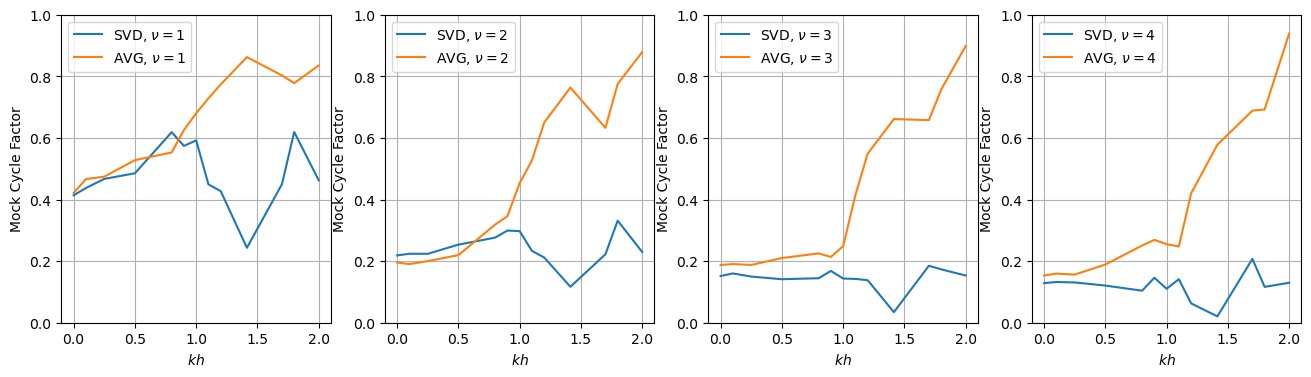

In [366]:
nu_values = np.arange(1, 5, dtype=int)
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

for i, nu in enumerate(nu_values):
    ax = axs[i]
    ax.plot(kh_values, result["svd, nu={}".format(nu)][1:], label="SVD, $\\nu={}$".format(nu))
    ax.plot(kh_values, result["avg, nu={}".format(nu)][1:], label="AVG, $\\nu={}$".format(nu))
    ax.set_xlabel("$kh$")
    ax.set_ylabel("Mock Cycle Factor");
    ax.legend();
    ax.grid(True);
    ax.set_ylim([0, 1]);